In [1]:
## load packages
suppressPackageStartupMessages({
  library(DESeq2)
  library(emmeans)
  library(ggsignif)
  library(Hmisc)
  library(janitor)
  library(patchwork)
  library(phyloseq)
  library(scales)
  library(tidyverse)
  library(vegan)
})

In [2]:
## paths to directories
repo <- file.path("/Users/abandla/Desktop/2_research/1_manuscripts/2_2020_brunei_peat_fire")
data <- file.path(repo, "1_data")
figures <- file.path(repo, "3_figures")

In [3]:
## set global theme options for plots
btp_theme <- theme(
  axis.text = element_text(size = 16, color = "black"),
  axis.text.y = element_text(margin = margin(0, 10, 0, 10)),
  axis.text.x = element_text(margin = margin(10, 0, 10, 0)),
  axis.title = element_text(size = 18),
  axis.ticks.length = unit(.25, "cm"),
  panel.border = element_rect(linewidth = 0.5, fill = NA),
  panel.background = element_rect(fill = NA),
  panel.grid = element_blank(),
  legend.text = element_text(size = 16),
  legend.title = element_text(size = 18),
  legend.key = element_rect(fill = NA),
  legend.background = element_rect(fill = NA)
)

In [4]:
## import phyloseq object
btp_fire_ps <- readRDS(file.path(data, "3_phyloseq", "2020_btp_fire_ps.rds"))
btp_fire_ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3928 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 3928 taxa by 7 taxonomic ranks ]

In [5]:
## compute archea:bacteria ratio
archaea_to_bacteria_ratio <- btp_fire_ps %>%
  tax_glom("Kingdom") %>%
  transform_sample_counts(., function(x) x / sum(x)) %>%
  psmelt() %>%
  select(Sample, Abundance, psf_type, depth, Kingdom) %>%
  pivot_wider(
    id_cols = c("Sample", "psf_type", "depth"),
    names_from = "Kingdom",
    values_from = "Abundance"
  ) %>%
  group_by(Sample) %>%
  mutate(ratio = Archaea / Bacteria) %>%
  ungroup

In [6]:
## ANOVA
archaea_to_bacteria_ratio_anova <- aov(ratio ~ psf_type * depth, data = archaea_to_bacteria_ratio)
summary(archaea_to_bacteria_ratio_anova)

               Df Sum Sq Mean Sq F value   Pr(>F)    
psf_type        1 0.2391 0.23911   14.45 0.001310 ** 
depth           2 0.3585 0.17926   10.83 0.000817 ***
psf_type:depth  2 0.3588 0.17940   10.84 0.000814 ***
Residuals      18 0.2980 0.01655                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [7]:
## pairwise comparisons
archaea_to_bacteria_ratio_anova_pairs <- emmeans(archaea_to_bacteria_ratio_anova, pairwise ~ psf_type | depth)$contrasts
archaea_to_bacteria_ratio_anova_pairs

depth = 0-5:
 contrast       estimate    SE df t.ratio p.value
 Burnt - Intact  -0.0419 0.091 18  -0.461  0.6504

depth = 35-40:
 contrast       estimate    SE df t.ratio p.value
 Burnt - Intact   0.1061 0.091 18   1.166  0.2588

depth = 95-100:
 contrast       estimate    SE df t.ratio p.value
 Burnt - Intact   0.5347 0.091 18   5.878  <.0001


In [8]:
## plot archaea:bacteria ratio
archaea_to_bacteria_ratio_figure <- archaea_to_bacteria_ratio %>%
  group_by(psf_type, depth) %>%
  ggplot(., aes(x = depth, y = ratio, color = psf_type)) +
  geom_point(position = position_dodge(width = 0.8), shape = 1, size = 4, stroke = 1.25) +
  geom_signif(
    xmin = c(0.8, 1.8), 
    xmax = c(1.2, 2.2), 
    y_position = c(0.3, 0.5), 
    annotations = c("ns", "ns"), 
    size = 0.5, 
    textsize = 6, 
    vjust = -0.3,
    family = "Helvetica",
    color = "black"
  ) +
  geom_signif(
    xmin = 2.8, 
    xmax = 3.2, 
    y_position = 1.05, 
    annotations = c("***"), 
    size = 0.5, 
    textsize = 8, 
    vjust = 0.3,
    family = "Helvetica",
    color = "black"
  ) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(
    aspect.ratio = 1,
    legend.position = "none"
  ) +
  scale_y_continuous(limits = c(0, 1.15)) +
  scale_x_discrete(labels = c("Surface", "Mid", "Deep")) +
  xlab("Depth") +
  ylab("Archaea:Bacteria ratio") +
  guides(shape = guide_legend(title = "Depth (cm)")) + 
  scale_color_manual(
    "PSF", 
    values = c("#e66101", "#1a9641"), 
    labels = c("Burnt", "Intact")
  )

In [9]:
## compute shannon diversity for archaea
shannon_diversity_archaea <- btp_fire_ps %>%
  subset_taxa(., Kingdom == "Archaea") %>%
  estimate_richness(., measures = "Shannon") %>%
  rownames_to_column("sample_name") %>%
  inner_join(
    .,
    sample_data(btp_fire_ps) %>%
      data.frame() %>%
      rownames_to_column("sample_name")
  ) %>%
  select(sample_name, Shannon, psf_type, depth)

Joining with `by = join_by(sample_name)`


In [10]:
## ANOVA
shannon_diversity_archaea_anova <- aov(Shannon ~ psf_type * depth, data = shannon_diversity_archaea)
summary(shannon_diversity_archaea_anova)

               Df Sum Sq Mean Sq F value Pr(>F)
psf_type        1  0.000 0.00000   0.000  0.997
depth           2  0.561 0.28064   0.914  0.419
psf_type:depth  2  0.095 0.04728   0.154  0.858
Residuals      18  5.528 0.30709               

In [11]:
## plot archaeal diversity
shannon_diversity_archaea_figure <- shannon_diversity_archaea %>%
  group_by(depth, psf_type) %>%
  ggplot(., aes(x = depth, y = Shannon, color = psf_type)) +
  geom_point(position = position_dodge(width = 0.8), shape = 1, size = 4, stroke = 1.25) +
  geom_signif(
    xmin = c(0.8, 1.8, 2.8), 
    xmax = c(1.2, 2.2, 3.2), 
    y_position = c(5, 5, 5),  
    annotations = c("ns", "ns", "ns"), 
    size = 0.5, 
    vjust = -0.3,
    textsize = 6, 
    family = "Helvetica",
    color = "black",
    tip_length = 0.1
  ) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(
    aspect.ratio = 1,
    legend.position = "none"
  ) +
  xlab("Depth") +
  ylab("Archaeal diversity") +
  scale_y_continuous(limits = c(0, 8)) +
  scale_x_discrete(labels = c("Surface", "Mid", "Deep")) +
  guides(
    shape = guide_legend(title = "Depth")
  ) + 
  scale_color_manual(
    "PSF", 
    values = c("#e66101", "#1a9641"), 
    labels = c("Burnt", "Intact")
  )

In [12]:
## compute shannon diversity for bacteria
shannon_diversity_bacteria <- btp_fire_ps %>%
  subset_taxa(., Kingdom != "Archaea") %>%
  estimate_richness(., measures = "Shannon") %>%
  rownames_to_column("sample_name") %>%
  inner_join(
    .,
    sample_data(btp_fire_ps) %>%
      data.frame() %>%
      rownames_to_column("sample_name")
  ) %>%
  select(sample_name, Shannon, psf_type, depth)

Joining with `by = join_by(sample_name)`


In [13]:
## ANOVA
shannon_diversity_bacteria_anova <- aov(Shannon ~ psf_type * depth, data = shannon_diversity_bacteria)
summary(shannon_diversity_bacteria_anova)

               Df Sum Sq Mean Sq F value  Pr(>F)   
psf_type        1 0.7831  0.7831   4.553 0.04688 * 
depth           2 0.7143  0.3572   2.076 0.15437   
psf_type:depth  2 2.4243  1.2122   7.047 0.00549 **
Residuals      18 3.0961  0.1720                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [14]:
## pairwise comparisons
shannon_diversity_bacteria_anova_pairs <- emmeans(shannon_diversity_bacteria_anova, pairwise ~ psf_type | depth)$contrasts
shannon_diversity_bacteria_anova_pairs

depth = 0-5:
 contrast       estimate    SE df t.ratio p.value
 Burnt - Intact    0.359 0.293 18   1.224  0.2369

depth = 35-40:
 contrast       estimate    SE df t.ratio p.value
 Burnt - Intact   -0.255 0.293 18  -0.871  0.3954

depth = 95-100:
 contrast       estimate    SE df t.ratio p.value
 Burnt - Intact   -1.187 0.293 18  -4.049  0.0008


In [15]:
## plot bacterial diversity
shannon_diversity_bacteria_figure <- shannon_diversity_bacteria %>%
  group_by(depth, psf_type) %>%
  ggplot(., aes(x = depth, y = Shannon, color = psf_type)) +
  geom_point(position = position_dodge(width = 0.8), shape = 1, size = 4, stroke = 1.25) +
  geom_signif(
    xmin = c(0.8, 1.8), 
    xmax = c(1.2, 2.2), 
    y_position = c(7.3, 7.3),  
    annotations = c("ns", "ns"), 
    size = 0.5,
    vjust = -0.3,
    textsize = 6, 
    family = "Helvetica",
    color = "black",
    tip_length = 0.07
  ) +
  geom_signif(
    xmin = 2.8, 
    xmax = 3.2, 
    y_position = 7.3,  
    annotations = c("***"), 
    size = 0.5,
    vjust = 0.3,
    textsize = 8, 
    family = "Helvetica",
    color = "black",
    tip_length = 0.07
  ) +
  coord_cartesian(clip = "off") +
  btp_theme +
  theme(
    aspect.ratio = 1,
    legend.position = "none"
  ) +
  xlab("Depth") +
  ylab("Bacterial diversity") +
  scale_y_continuous(limits = c(0, 8)) +
  scale_x_discrete(labels = c("Surface", "Mid", "Deep")) +
  guides(
    shape = guide_legend(title = "Depth")
  ) + 
  scale_color_manual(
    "PSF", 
    values = c("#e66101", "#1a9641"), 
    labels = c("Burnt", "Intact")
  )

In [16]:
## function to compute ordination ellipses
veganCovEllipse<-function (cov, center = c(0, 0), scale = 1, npoints = 100) 
{
  theta <- (0:npoints) * 2 * pi/npoints
  Circle <- cbind(cos(theta), sin(theta))
  t(center + scale * t(Circle %*% chol(cov)))
}

In [17]:
## archaea constrained analysis of principle coordinates
archaea_cap <- ordinate(
  btp_fire_ps %>%
    subset_taxa(., Kingdom == "Archaea") %>%
    transform_sample_counts(., function(x) sqrt(x / sum(x))),
  "CAP", "bray", ~psf_type
)

In [18]:
## constrained analysis of principle coordinates ANOVA
anova.cca(archaea_cap)

,Df,SumOfSqs,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,0.5543374,2.655888,0.043
Residual,22,4.5918443,NA,NA


In [19]:
## merge with metadata
archaea_cap_df <- archaea_cap %>%
  scores(.) %>%
  .$sites %>%
  data.frame() %>%
  cbind(sample_data(btp_fire_ps)) %>%
  group_by(psf_type, depth) %>%
  mutate(index = factor(cur_group_id()))

In [20]:
## estimate centroids
archaea_cap_centroids <- archaea_cap_df %>%
  summarise(CAP1 = mean(CAP1), MDS1 = mean(MDS1))

`summarise()` has grouped output by 'psf_type'. You can override using the
`.groups` argument.


In [21]:
## extract data to plot
archaea_cap_ellipse <- data.frame()
for (g in levels(archaea_cap_df$index)) {
  archaea_cap_ellipse <- rbind(archaea_cap_ellipse, cbind(as.data.frame(with(
    archaea_cap_df[archaea_cap_df$index == g, ],
    veganCovEllipse(
      cov.wt(cbind(CAP1, MDS1),
        wt = rep(1 / length(CAP1), length(CAP1)))$cov,
      center = c(mean(CAP1), mean(MDS1))
    )
  )),
    index = g
  ))
}

In [22]:
## plot constrained analysis of principle coordinates
archaea_cap_figure <- ggplot(data = archaea_cap_ellipse) +
  geom_polygon(
    aes(x = CAP1, y = MDS1, group = index),
    fill = "#f0f0f0",
    alpha = 0.9
  ) +
  geom_point(
    data = archaea_cap_centroids,
    aes(x = CAP1, y = MDS1, color = psf_type, shape = depth),
    size = 5,
    stroke = 1.25
  ) +
  coord_fixed(clip = "off") +
  btp_theme +
  theme(legend.position = "none") +
  annotate("text", label = "Archaea", x = 1.12, y = 0.95, size = 6) +
  scale_color_manual("Fire", values = c("#e66101", "#1a9641"), labels = c("Burnt", "Intact")) +
  scale_shape_manual("Depth", values = c(0, 1, 3)) +
  scale_y_continuous(limits = c(-1.5, 1), breaks = c(-1, 0, 1)) +
  scale_x_continuous(limits = c(-2.2, 1.5)) +
  guides(shape = guide_legend(title = "Depth")) +
  xlab("CAP1 [10.7%]") +
  ylab("MDS1 [38.9%]")

In [23]:
## bacteria constrained analysis of principle coordinates
bacteria_cap <- ordinate(
  btp_fire_ps %>%
    subset_taxa(., Kingdom == "Bacteria") %>%
    transform_sample_counts(., function(x) sqrt(x / sum(x))),
  "CAP", "bray", ~psf_type
)

In [24]:
## constrained analysis of principle coordinates ANOVA
anova.cca(bacteria_cap)

,Df,SumOfSqs,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,0.493042,2.408004,0.018
Residual,22,4.504528,NA,NA


In [25]:
## merge with metadata
bacteria_cap_df <- bacteria_cap %>%
  scores(.) %>%
  .$sites %>%
  data.frame() %>%
  cbind(sample_data(btp_fire_ps)) %>%
  group_by(psf_type, depth) %>%
  mutate(index = factor(cur_group_id()))

In [26]:
## estimate centroids
bacteria_cap_centroids <- bacteria_cap_df %>%
  summarise(CAP1 = mean(CAP1), MDS1 = mean(MDS1))

`summarise()` has grouped output by 'psf_type'. You can override using the
`.groups` argument.


In [27]:
## extract data to plot
bacteria_cap_ellipse <- data.frame()
for (g in levels(bacteria_cap_df$index)) {
  bacteria_cap_ellipse <- rbind(bacteria_cap_ellipse, cbind(as.data.frame(with(
    bacteria_cap_df[bacteria_cap_df$index == g, ],
    veganCovEllipse(
      cov.wt(cbind(CAP1, MDS1),
        wt = rep(1 / length(CAP1), length(CAP1)))$cov,
      center = c(mean(CAP1), mean(MDS1))
    )
  )),
    index = g
  ))
}

In [28]:
## plot constrained analysis of principle coordinates
bacteria_cap_figure <- ggplot(data = bacteria_cap_ellipse) +
  geom_polygon(
    aes(x = CAP1, y = MDS1, group = index),
    fill = "#f0f0f0",
    alpha = 0.9
  ) +
  geom_point(
    data = bacteria_cap_centroids,
    aes(x = CAP1, y = MDS1, color = psf_type, shape = depth),
    size = 5,
    stroke = 1.25
  ) +
  coord_fixed(clip = "off") +
  btp_theme +
  theme(legend.position = "none") +
  annotate("text", label = "Bacteria", x = 1.12, y = 0.95, size = 6) +
  scale_color_manual("Fire", values = c("#e66101", "#1a9641"), labels = c("Burnt", "Intact")) +
  scale_shape_manual("Depth", values = c(0, 1, 3)) +
  scale_y_continuous(limits = c(-1.5, 1), breaks = c(-1, 0, 1)) +
  scale_x_continuous(limits = c(-2.4, 1.5)) +
  guides(shape = guide_legend(title = "Depth")) +
  xlab("CAP1 [9.9%]") +
  ylab("MDS1 [27%]")

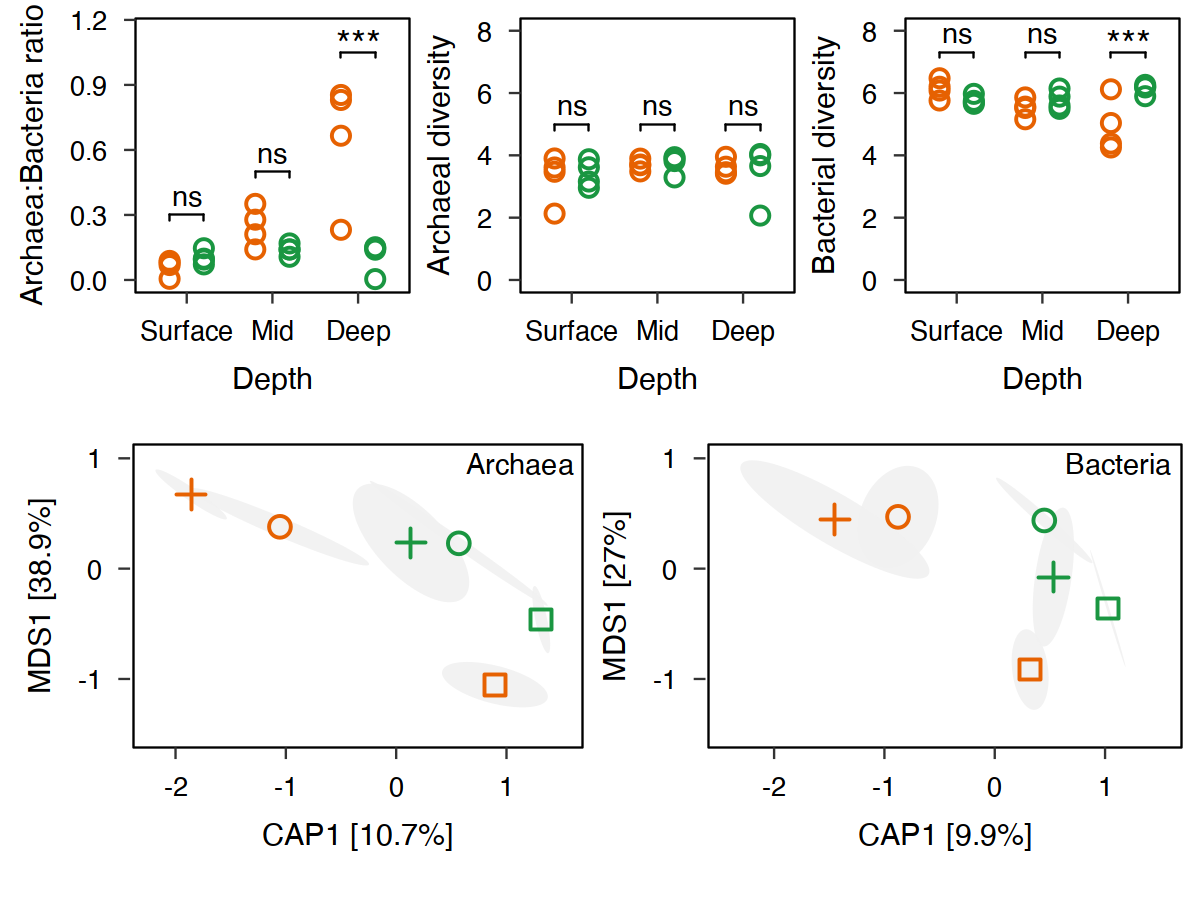

In [29]:
## compose plot
options(repr.plot.width = 10, repr.plot.height = 7.5)
(archaea_to_bacteria_ratio_figure + shannon_diversity_archaea_figure + shannon_diversity_bacteria_figure) /
(archaea_cap_figure + bacteria_cap_figure) + plot_layout(heights = c(3, 4))